# 08 Analysis of spatial transcriptomics

- Åsa Björklund
- Paulo Czarnewski

- Spatial Omics Data Analysis 2022

In this tutorial, we will perform analysis of the spatial transcriptomics data (10X Visium technology), which will be used in combination with the single cell and the _in situ_ sequencing data to produce even more refined results. Please note that this tutorial is a brief overview of the methods and functions commonly used for single cell, too. If you are unfaminiar with such analysis, we recomend you to follow first the Single Cell Data Analysis course: https://nbisweden.github.io/workshop-scRNAseq/exercises

***

## Loading libraries

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import scanorama
import os

sc.settings.set_figure_params(dpi=80)
# sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

***

## Loading the dataset

In [2]:
adata = sc.read_h5ad('../results/spatial_transcriptomics/visium.h5ad')
adata

/Users/asbj/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 716 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

As you can see, we now have the slot spatial in obsm, which contains the spatial information from the Visium platform. We can plot the tissues stored in the object with this code below.

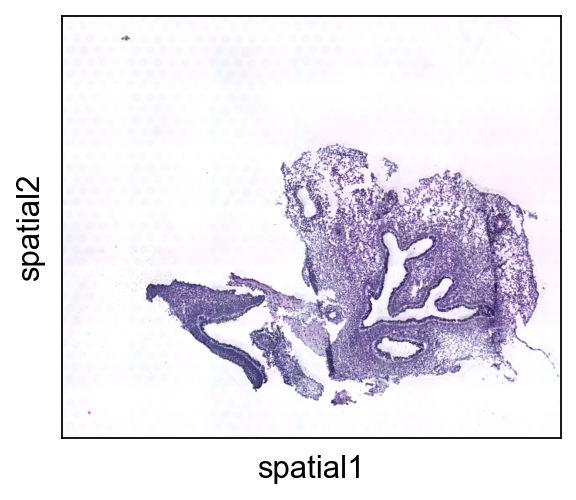

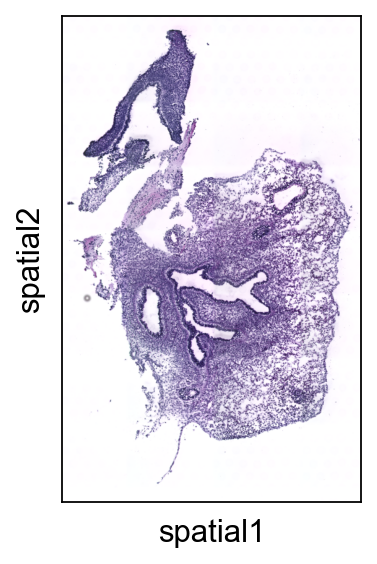

In [3]:
for library in adata.obs.sample_id.unique():
    sc.pl.spatial(
        adata[adata.obs.sample_id == library,:], 
        library_id=library)

As you can see, we have 2 consecutive slides from the same tissue, but rotated about 90 degrees. We will explore later how to combine them, but for now, lets continue performin the data analysis.

***

##  Quality control

Similar to scRNAseq we use statistics on number of counts, number of features and percent mitochondria for quality control.

In [4]:
# add info on mitochondrial and hemoglobin genes to the objects.
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
adata.var['hb'] = adata.var_names.str.contains(("^HB[AB]"))
adata.var['ribo'] = adata.var_names.str.contains(("^RP[LS]"))

sc.pp.calculate_qc_metrics(
    adata, qc_vars=['mt','hb','ribo'], 
    percent_top=None, log1p=False, inplace=True)

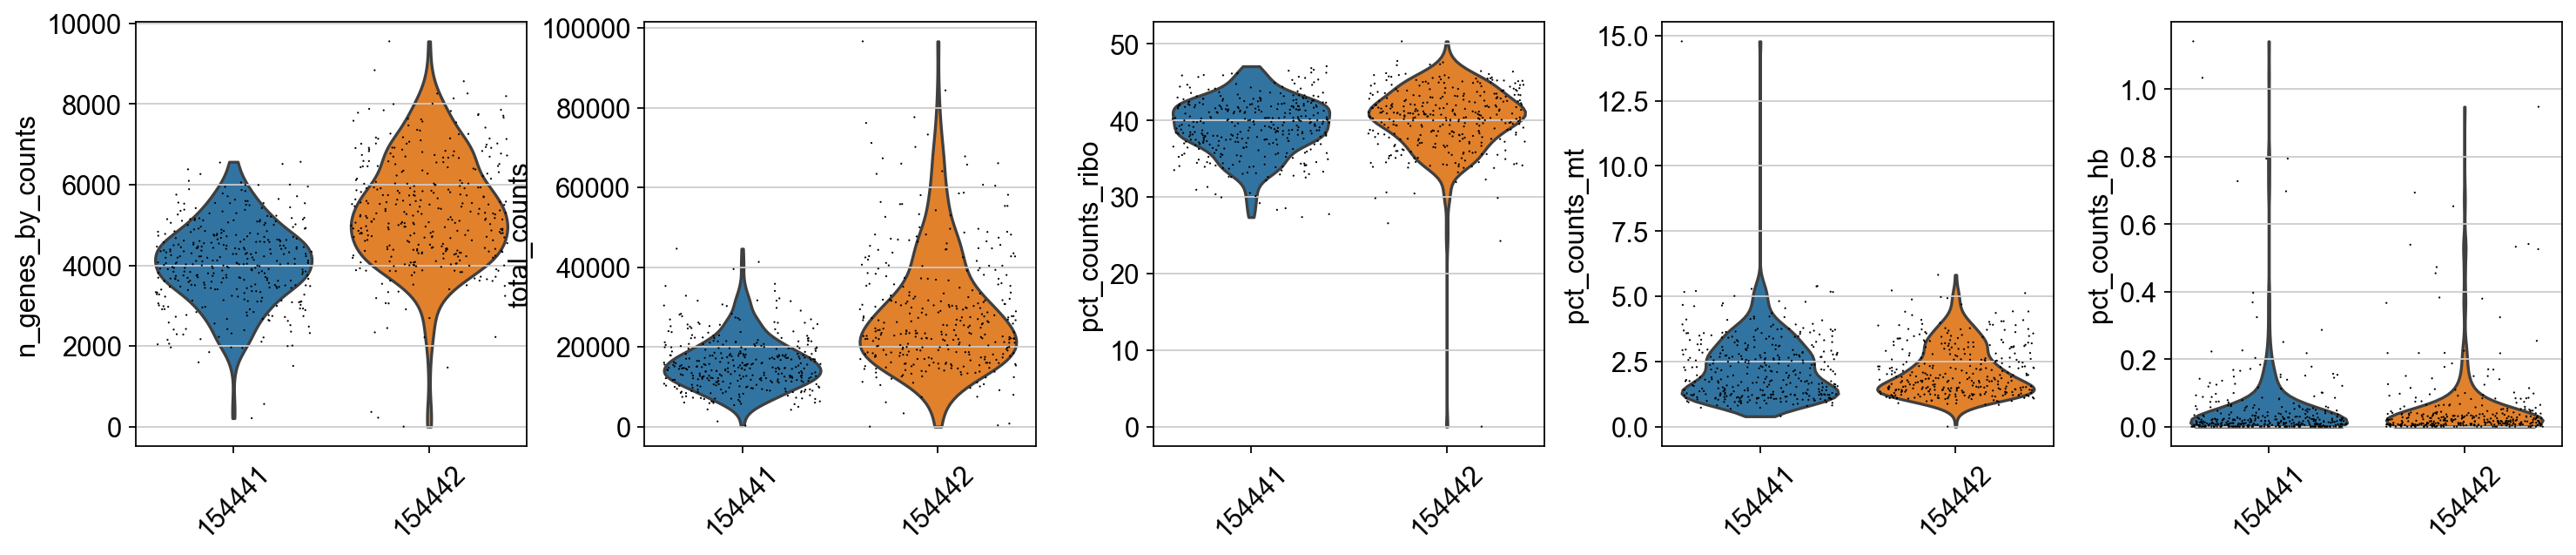

In [5]:
sc.pl.violin(adata, 
             keys = ['n_genes_by_counts', 'total_counts','pct_counts_ribo',
                     'pct_counts_mt', 'pct_counts_hb'],
             jitter=0.4, groupby = 'sample_id', rotation= 45)

We can also plot the same data onto the tissue section. In `scanpy`, this is a bit tricky when you have multiple sections, as you would have to subset and plot them separately.

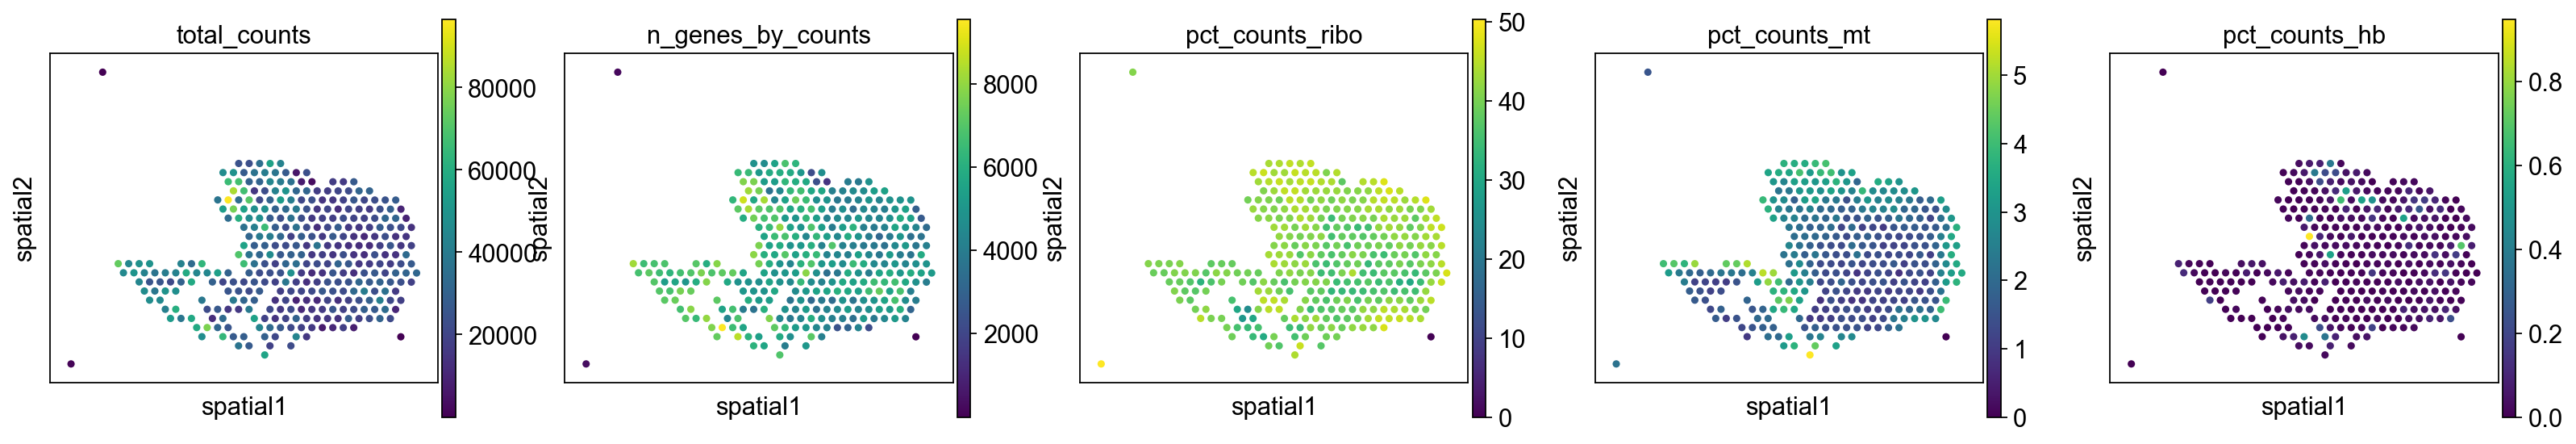

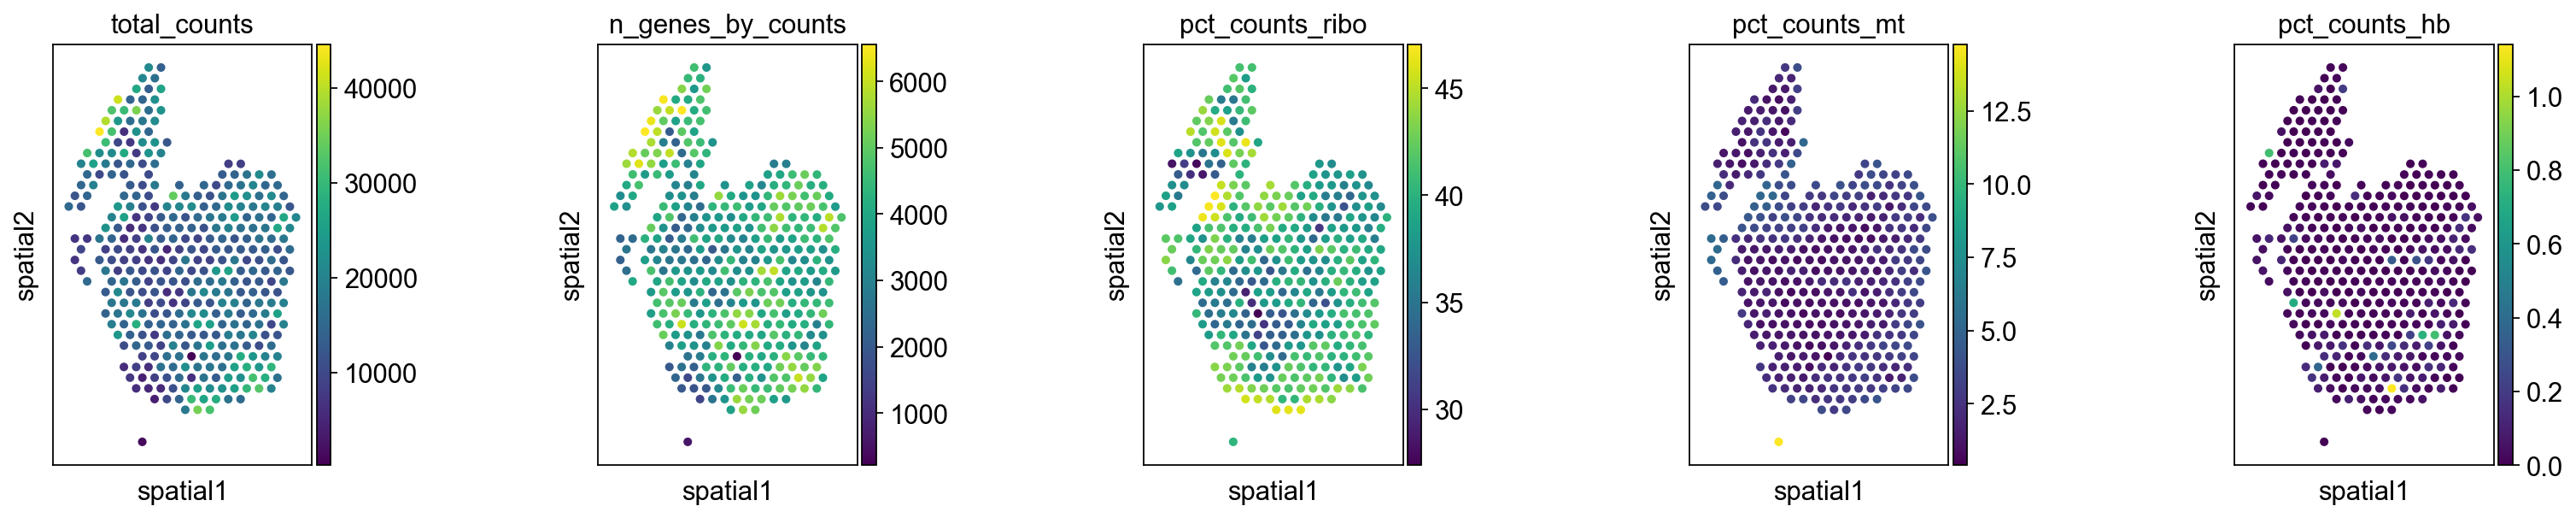

In [6]:
for library in adata.obs.sample_id.unique():
    sc.pl.spatial(
        adata[adata.obs.sample_id == library,:], 
        library_id=library, color = [
            'total_counts', 'n_genes_by_counts','pct_counts_ribo',
            'pct_counts_mt', 'pct_counts_hb'],ncols=5,
        alpha_img=0)

As you can see, the spots with low number of counts/features and high mitochondrial content is mainly towards the edges of the tissue. You may also see regions within a tissue with low quality if you have tears or folds in your section. But remember, for some tissue types, the amount of genes expressed and proportion mitochondria may also be a biologicaly meaningfull, so bear in mind what tissue you are working on and what these features mean.

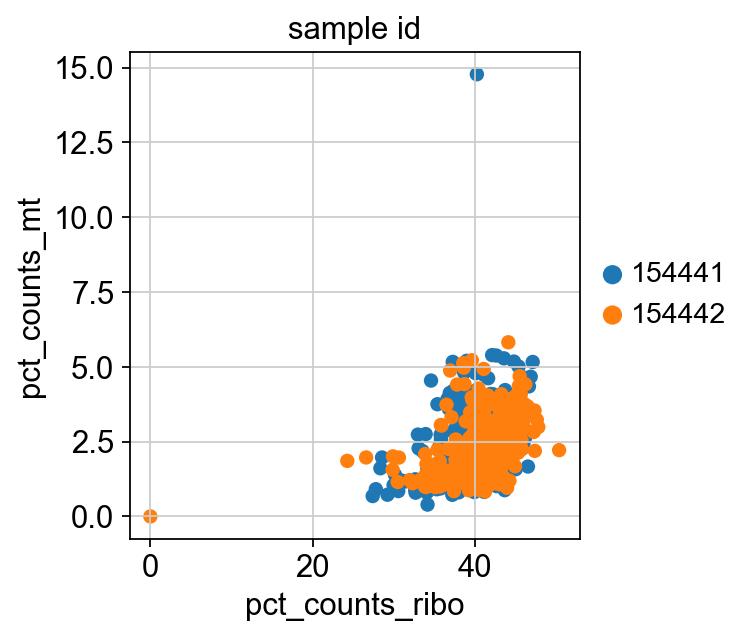

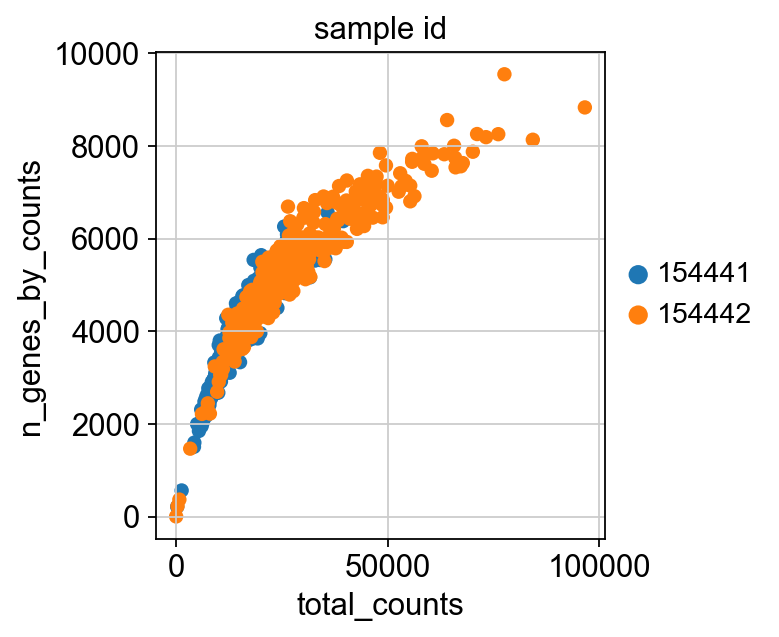

In [7]:
sc.pl.scatter(adata, x='pct_counts_ribo', y='pct_counts_mt', color="sample_id")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="sample_id")

## Top expressed genes

normalizing counts per cell
    finished (0:00:00)


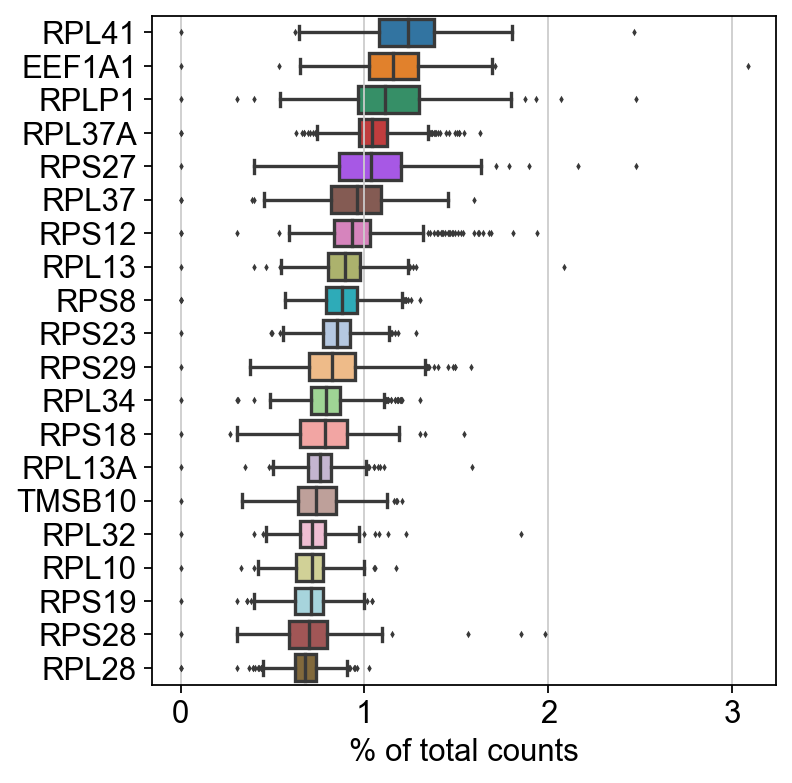

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

***

##  Spot and Gene Filtering

Select all spots with less than 10% mitocondrial reads and more than 20% ribossomal reads. You must judge for yourself based on your knowledge of the tissue what are appropriate filtering criteria for your dataset.

In this case the filtering criteria is selected to remove spots that are outside of the tissue and that clearly has lower quality.

In [9]:
print(adata.shape)
remove = adata.var_names.str.startswith('MT-')
keep = np.invert(remove)

adata = adata[:,keep]


adata = adata[adata.obs['pct_counts_mt'] < 10,:]
adata = adata[adata.obs['pct_counts_ribo'] > 20,:]
print(adata.shape)

(716, 33538)
(714, 33525)


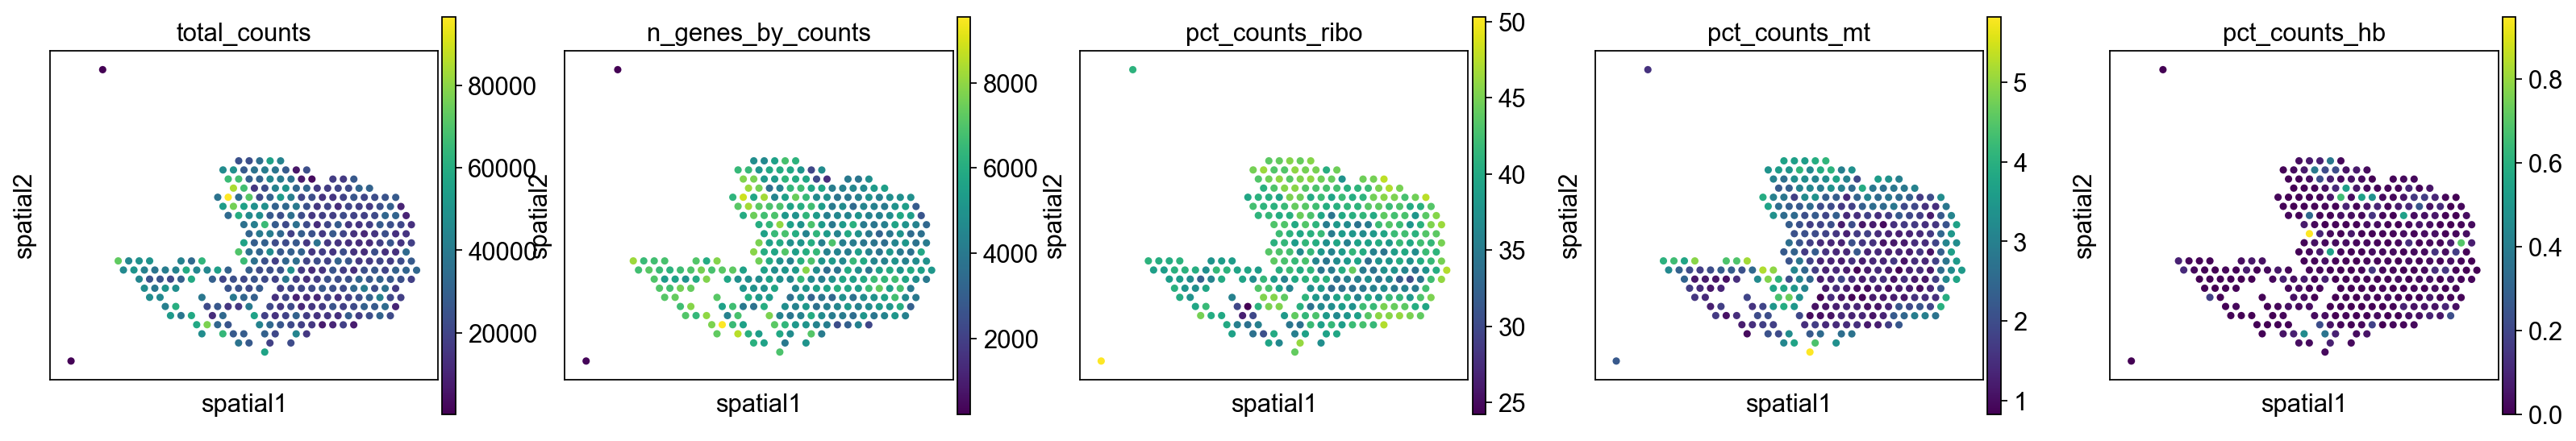

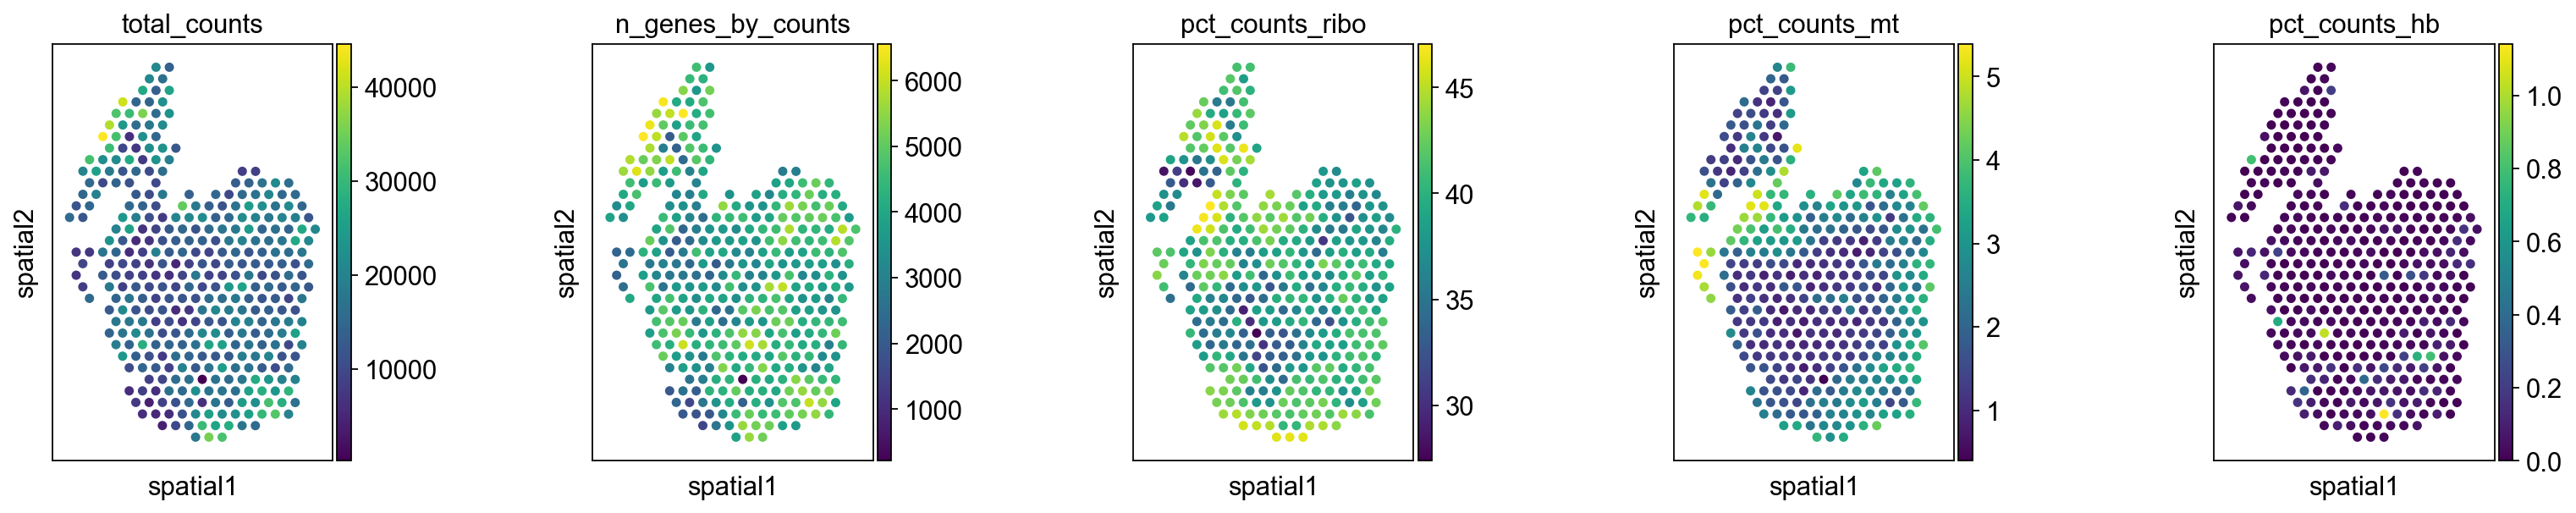

In [10]:
for library in adata.obs.sample_id.unique():
    sc.pl.spatial(
        adata[adata.obs.sample_id == library,:], 
        library_id=library, color = [
            'total_counts', 'n_genes_by_counts','pct_counts_ribo',
            'pct_counts_mt', 'pct_counts_hb'],ncols=5,
        alpha_img=0)

As you can see, two of the spots outside the tissue are removed with this cutoff. But two spots outside the tissue remains for the first section, and we do not want to increase the cutoffs to also remove too many spots in the tissue section. These can be removed by marking them in an interactive viewer like Napari. Or by defining the coordintes as we do below. 

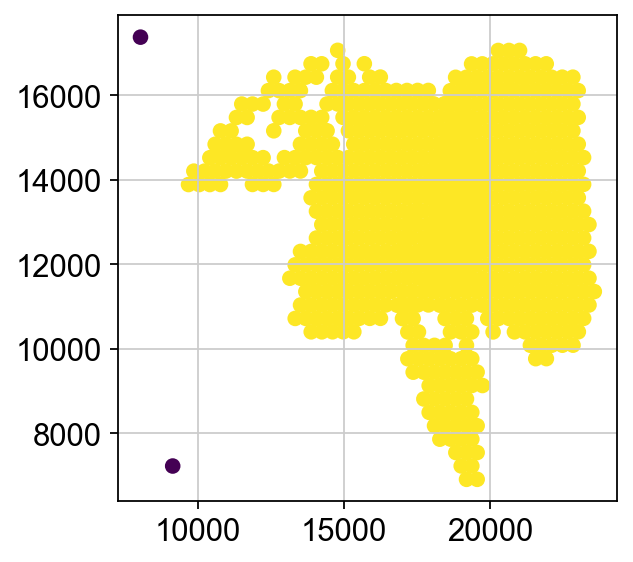

(712, 33525)


In [11]:
sel = adata.obsm['spatial'][:,0]>9200
plt.scatter(adata.obsm['spatial'][:,0],adata.obsm['spatial'][:,1], c=sel)
plt.show()

adata = adata[sel,:]
print(adata.shape)

***

## Normalization

Before cell cycle and variable gene selection we have to normalize the data. In the scanpy object, the data slot will be overwritten with the normalized data. So first, save the raw data into the slot raw. Here, we perform the log(CP10K) normalization.

In [12]:
# save raw counts in raw slot.
#adata.raw = adata

# normalize to depth 10000 UMIs per cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# save lognormalized counts in raw slot.
adata.raw = adata

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


/Users/asbj/miniconda3/envs/spatial2022/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell
/Users/asbj/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/asbj/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


***

## Calculate cell-cycle scores

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site at [RegevLab Github repo](https://github.com/theislab/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt) with the code below.

In [13]:
cc_file = '../results/regev_lab_cell_cycle_genes.txt'

if not os.path.exists(cc_file):
    from urllib import request
    request.urlretrieve( 'https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt' , cc_file )


In [14]:
# Load gene list from file
cell_cycle_genes = [x.strip() for x in open('../results/regev_lab_cell_cycle_genes.txt')]

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

# Filter out genes not detectd in our dataset 
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [15]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    428 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    343 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


We can now plot a violin plot for the cell cycle scores as well.

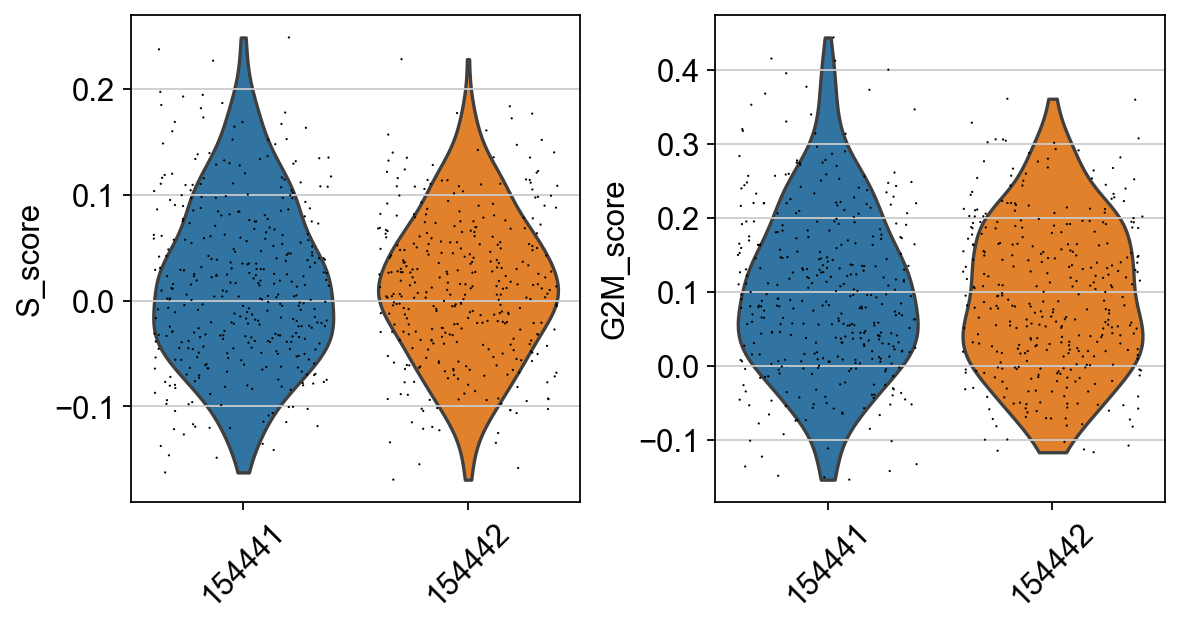

In [16]:
sc.pl.violin(adata, ['S_score', 'G2M_score'], jitter=0.4, groupby = 'sample_id', rotation=45)

***

## Variable feature selection

Next, we first need to define which features/genes are important in our dataset to distinguish cell types. For this purpose, we need to find genes that are highly variable across cells, which in turn will also provide a good separation of the cell clusters.

As we have two sections, we will select variable genes with batch_key="library_id" and then take the union of variable genes for further analysis. The idea is to avoid including batch specific genes in the analysis.

In [17]:
sc.pp.highly_variable_genes(
    adata=adata, flavor="seurat", 
    n_top_genes=2000, inplace=True, 
    batch_key="sample_id")

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [18]:
adata.var

gene_ids    feature_types  genome     mt     hb   ribo  \
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False  False  False   
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False  False  False   
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False  False  False   
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False  False  False   
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False  False  False   
...                      ...              ...     ...    ...    ...    ...   
AC233755.2   ENSG00000277856  Gene Expression  GRCh38  False  False  False   
AC233755.1   ENSG00000275063  Gene Expression  GRCh38  False  False  False   
AC240274.1   ENSG00000271254  Gene Expression  GRCh38  False  False  False   
AC213203.1   ENSG00000277475  Gene Expression  GRCh38  False  False  False   
FAM231C      ENSG00000268674  Gene Expression  GRCh38  False  False  False   

             n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
MIR1302-2HG                  0     0.000000             100.000000   
FAM138A                      0     0.000000             100.000000   
OR4F5                        0     0.000000             100.000000   
AL627309.1                   6     0.008380              99.162011   
AL627309.3                   0     0.000000             100.000000   
...                        ...          ...                    ...   
AC233755.2                   0     0.000000             100.000000   
AC233755.1                   0     0.000000             100.000000   
AC240274.1                   2     0.002793              99.720670   
AC213203.1                   0     0.000000             100.000000   
FAM231C                      0     0.000000             100.000000   

             total_counts  highly_variable     means  dispersions  \
MIR1302-2HG           0.0            False  0.000000     0.000000   
FAM138A               0.0            False  0.000000     0.000000   
OR4F5                 0.0            False  0.000000     0.000000   
AL627309.1            6.0            False  0.003006    -0.943224   
AL627309.3            0.0            False  0.000000     0.000000   
...                   ...              ...       ...          ...   
AC233755.2            0.0            False  0.000000     0.000000   
AC233755.1            0.0            False  0.000000     0.000000   
AC240274.1            2.0            False  0.002209    -0.692077   
AC213203.1            0.0            False  0.000000     0.000000   
FAM231C               0.0            False  0.000000     0.000000   

             dispersions_norm  highly_variable_nbatches  \
MIR1302-2HG          0.000000                         0   
FAM138A              0.000000                         0   
OR4F5                0.000000                         0   
AL627309.1          -1.327940                         0   
AL627309.3           0.000000                         0   
...                       ...                       ...   
AC233755.2           0.000000                         0   
AC233755.1           0.000000                         0   
AC240274.1          -0.310476                         1   
AC213203.1           0.000000                         0   
FAM231C              0.000000                         0   

             highly_variable_intersection  
MIR1302-2HG                         False  
FAM138A                             False  
OR4F5                               False  
AL627309.1                          False  
AL627309.3                          False  
...                                   ...  
AC233755.2                          False  
AC233755.1                          False  
AC240274.1                          False  
AC213203.1                          False  
FAM231C                             False  

[33525 rows x 16 columns]

In [19]:
# subset for the variable genes in either of the batches.
adata = adata[:,adata.var.highly_variable_nbatches > 0]

Now we can plot gene expression of individual genes.

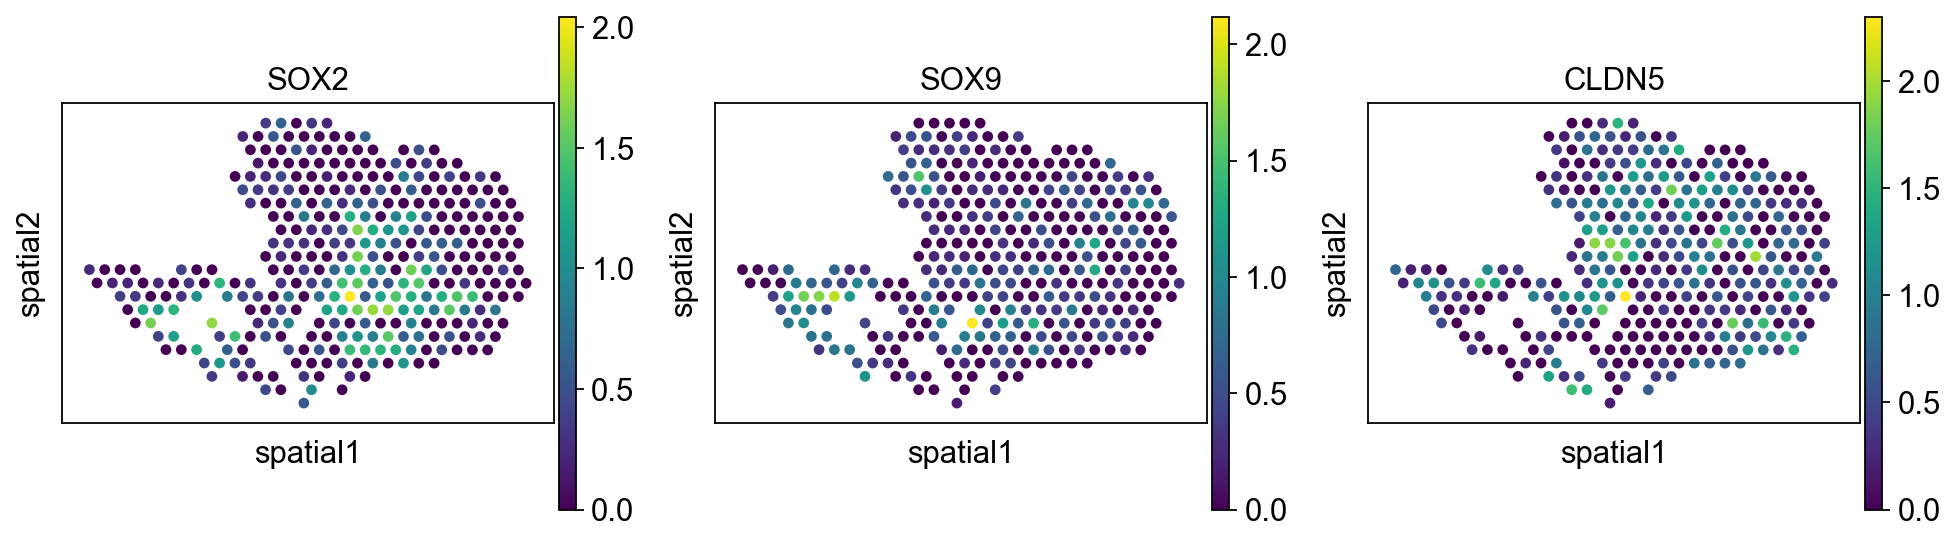

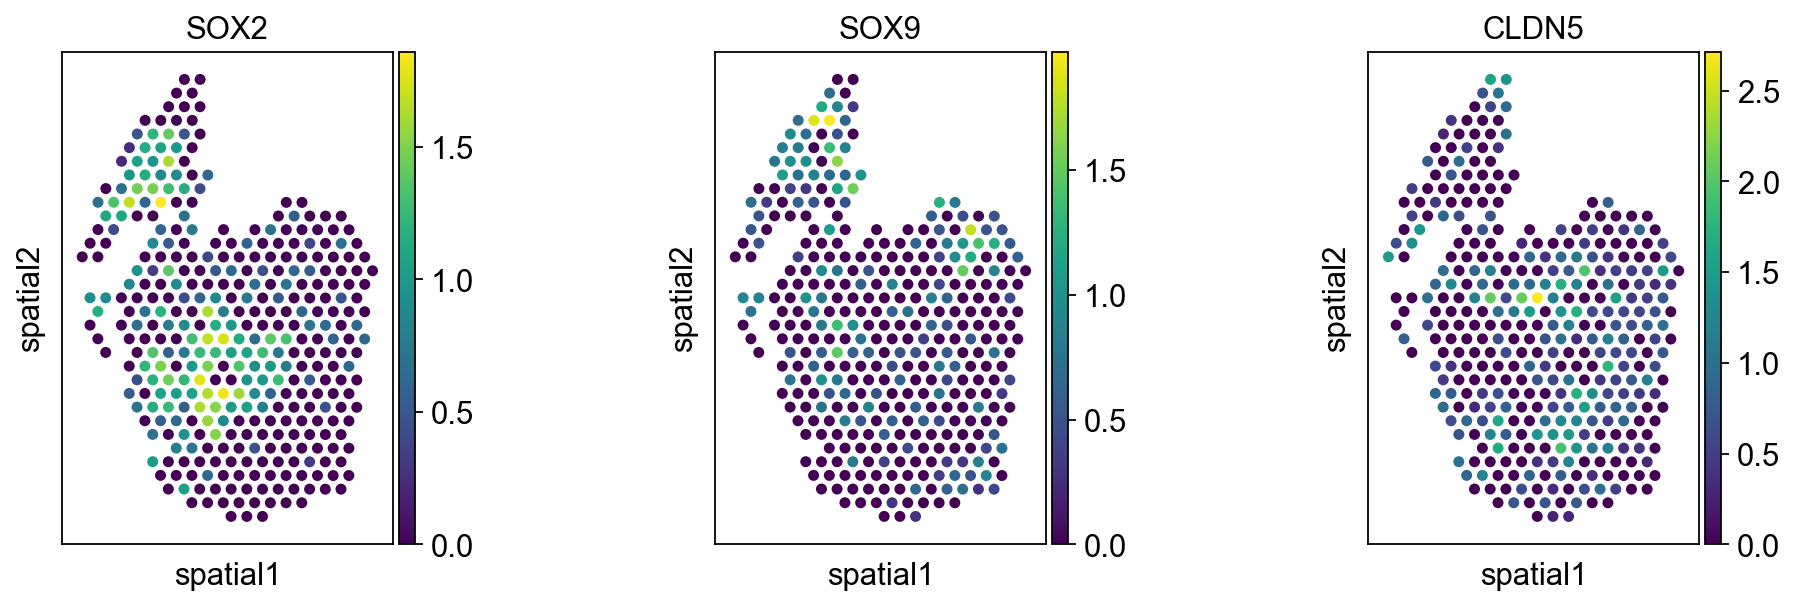

In [20]:
library_names = list(adata.uns['spatial'].keys())

for library in adata.obs.sample_id.unique():
    sc.pl.spatial(
        adata[adata.obs.sample_id == library,:], 
        library_id=library, color = [
            'SOX2','SOX9','CLDN5'],ncols=5,
        alpha_img=0)

In [21]:
# test clustering without integration

#sc.pp.scale(adata)


sc.pp.neighbors(adata)
sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 1.2, key_added = 'clusters_nonint')






computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50


/Users/asbj/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
running Leiden clustering
    finished: found 12 clusters and added
    'clusters_nonint', the cluster labels (adata.obs, categorical) (0:00:00)


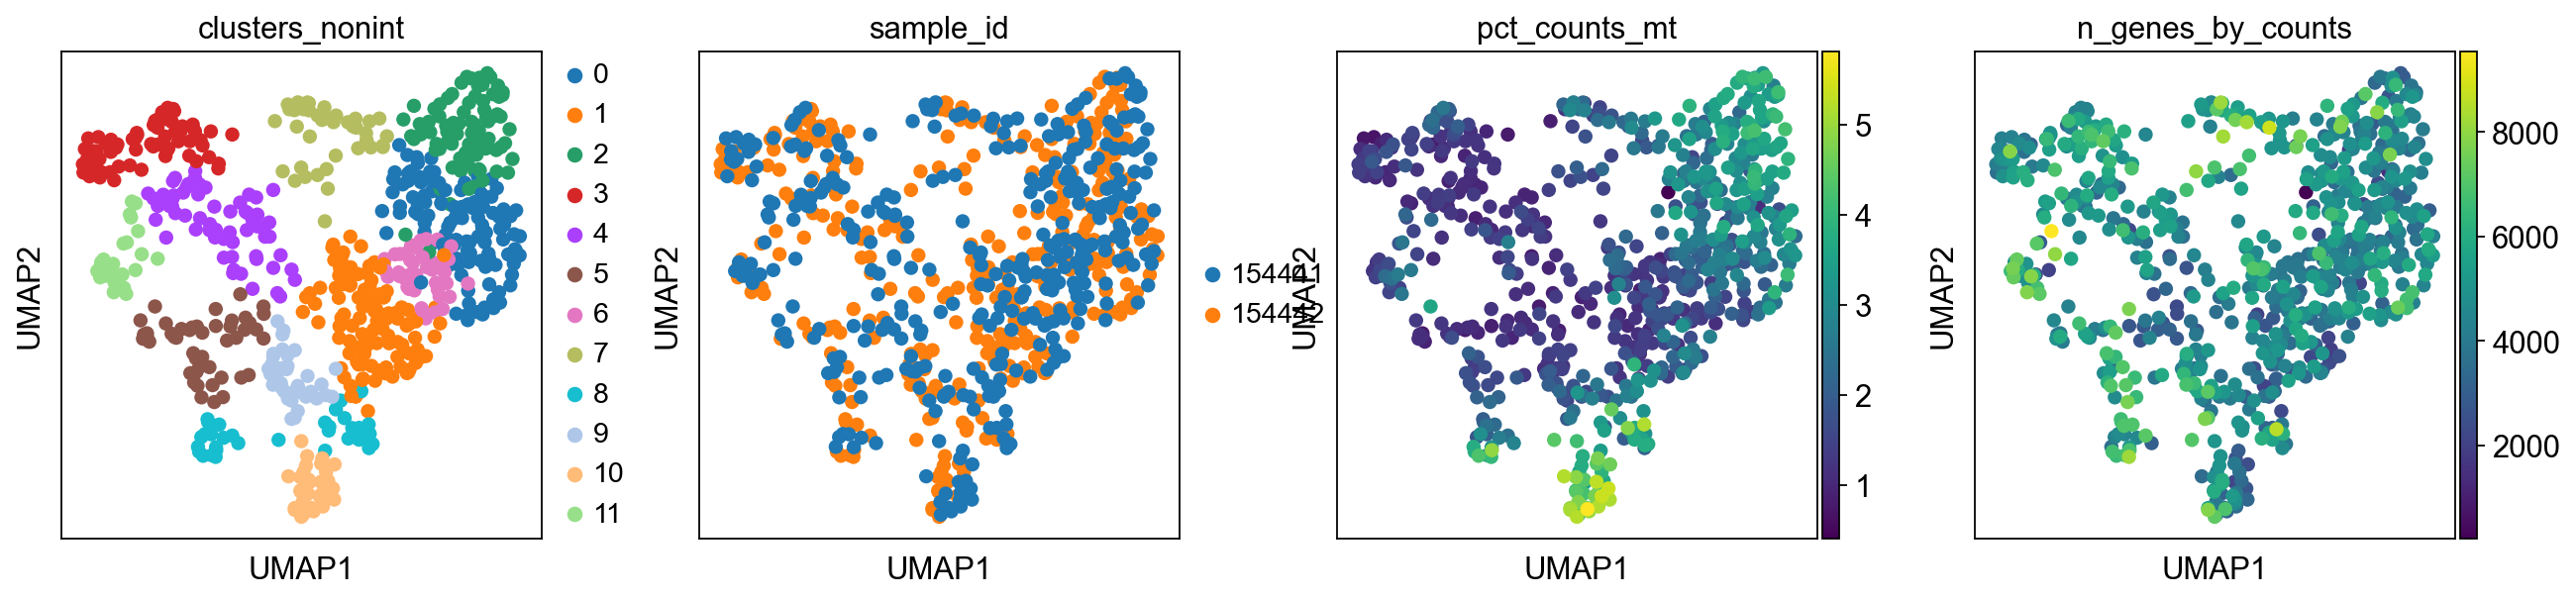

In [22]:
sc.pl.umap(
    adata, color=["clusters_nonint", "sample_id", "pct_counts_mt", "n_genes_by_counts"], palette=sc.pl.palettes.default_20
)


***

## Data integration

Quite often there are strong batch effects between different ST sections, so it may be a good idea to integrate the data across sections. We will do a similar integration as for the single cell dataset, using Scanorama.

In [23]:
adatas = {}
for batch in adata.obs.sample_id.unique():
    adatas[batch] = adata[adata.obs['sample_id'] == batch,]

adatas 

{'154442': View of AnnData object with n_obs × n_vars = 344 × 3324
     obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'S_score', 'G2M_score', 'phase', 'clusters_nonint'
     var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
     uns: 'spatial', 'sample_id_colors', 'log1p', 'hvg', 'neighbors', 'umap', 'leiden', 'clusters_nonint_colors'
     obsm: 'spatial', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities',
 '154441': View of AnnData object with n_obs × n_vars = 368 × 3324
     obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts

In [24]:
#convert to list of AnnData objects
adatas = list(adatas.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)


# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object
adata.obsm["Scanorama"] = all_s

Found 3324 genes among all datasets
[[0.         0.99709302]
 [0.         0.        ]]
Processing datasets (0, 1)
(712, 50)


***

## Dimensionality reduction and clustering

We can then now run dimensionality reduction and clustering using the same workflow as we use for scRNA-seq analysis.

In [25]:
sc.pp.neighbors(adata,use_rep="Scanorama")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [26]:
sc.tl.leiden(adata, resolution = 1.2, key_added = 'clusters')

running Leiden clustering
    finished: found 12 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


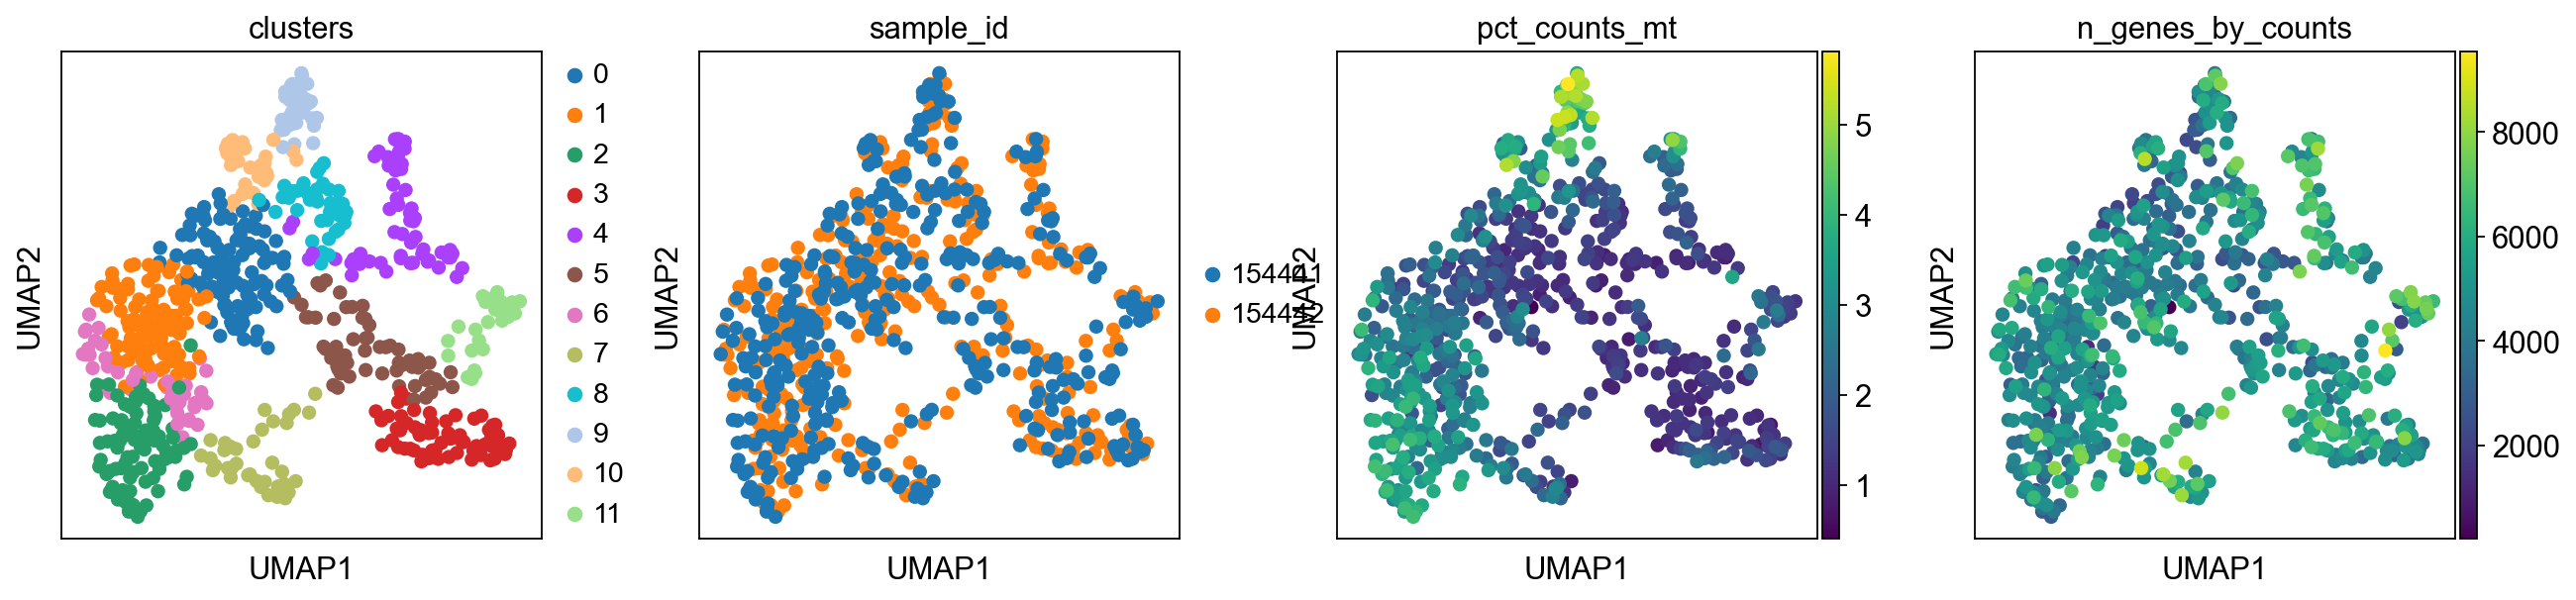

In [27]:

sc.pl.umap(
    adata, color=["clusters", "sample_id", "pct_counts_mt", "n_genes_by_counts"], palette=sc.pl.palettes.default_20
)

As we have new clusters, we again need to make a new dict for cluster colors

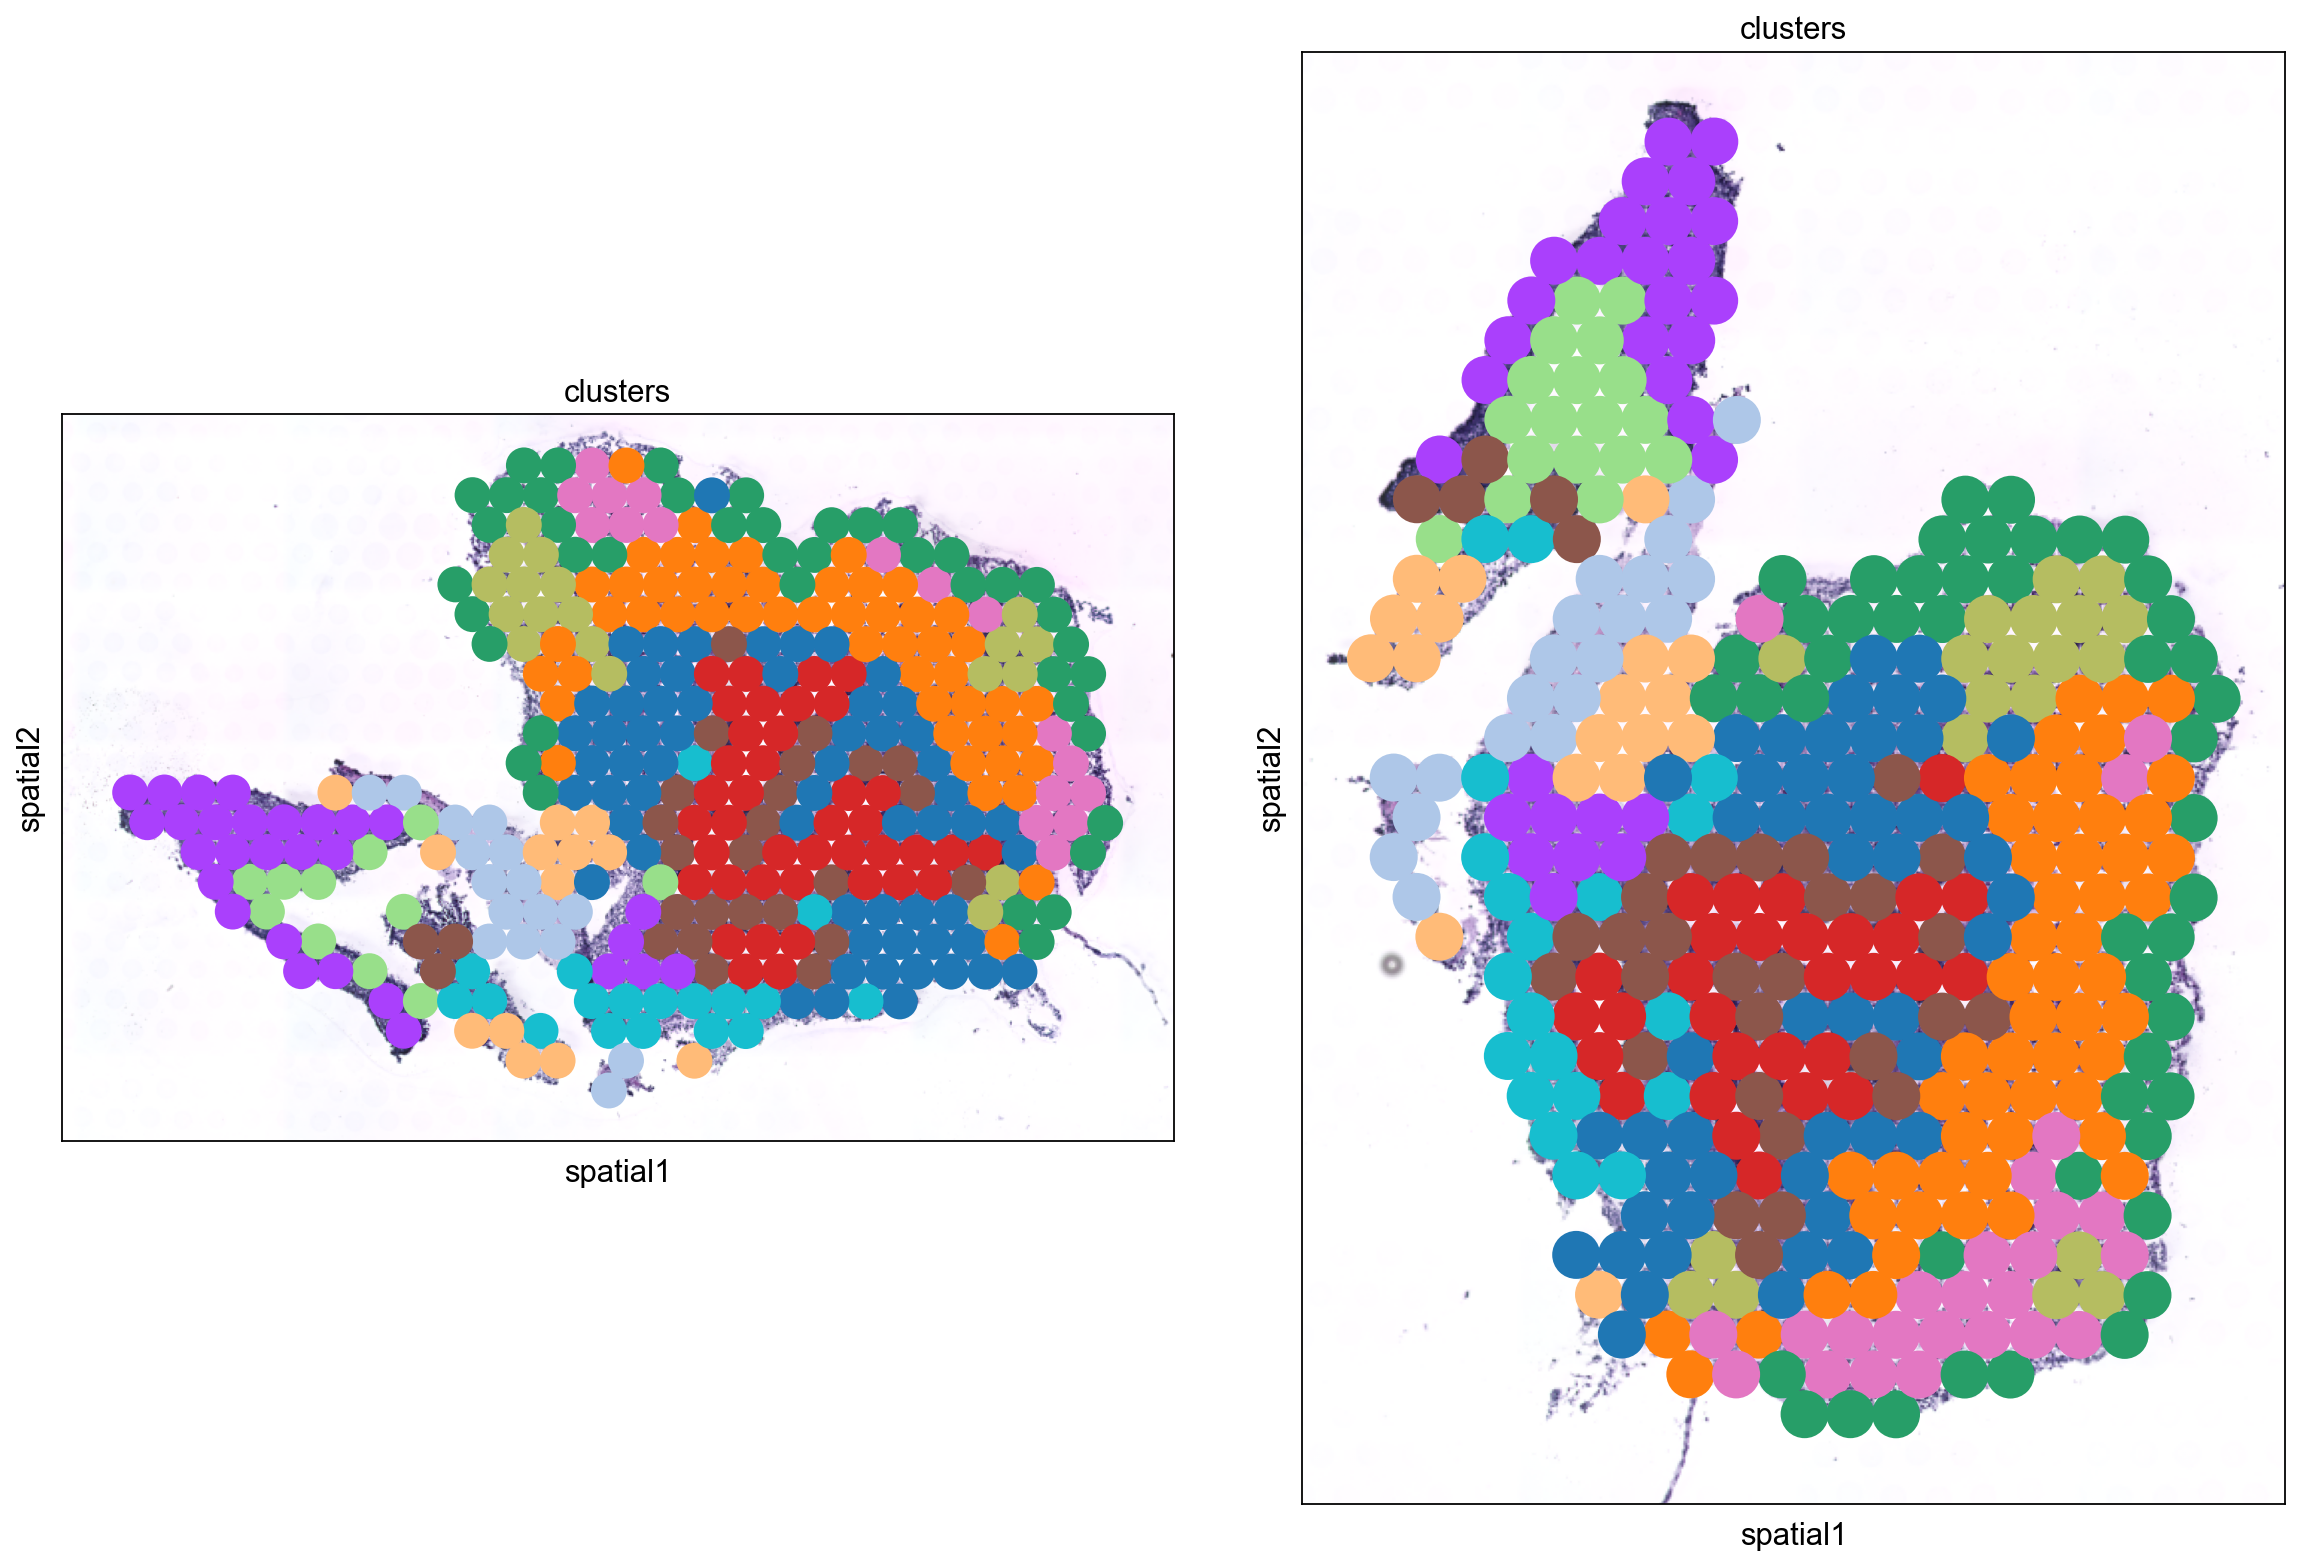

In [28]:
clusters_colors = dict(
    zip([str(i) for i in range(len(adata.obs.clusters.cat.categories))], adata.uns["clusters_colors"])
)


fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i, library in enumerate(
    adata.obs.sample_id.unique()
):
    ad = adata[adata.obs.sample_id == library, :].copy()
    sc.pl.spatial(
        ad,
        img_key="hires",
        library_id=library,
        color="clusters",
        size=1.5,
        palette=[
            v
            for k, v in clusters_colors.items()
            if k in ad.obs.clusters.unique().tolist()
        ],
        legend_loc=None,
        show=False,
        ax=axs[i],
    )

plt.tight_layout()

Lets save the integrated data for further analysis.

In [29]:
os.makedirs('../results/spatial_transcriptomics', exist_ok=True)
adata.write_h5ad('../results/spatial_transcriptomics/spatial_transcriptomics_qc_int_dr_cl.h5ad')

***

## Differential gene expression

Once we have done clustering, let's compute a ranking for the highly differential genes in each cluster.
Differential expression is performed with the function rank_genes_group. The default method to compute differential expression is the t-test_overestim_var. Other implemented methods are: logreg, t-test and wilcoxon.

By default, the `.raw` attribute of AnnData is used in case it has been initialized, it can be changed by setting `use_raw=False`. The `leiden_0.6` clustering resolution seems to give a reasonable number of clusters, so we will use that clustering for all DE tests.

In [30]:
adata = sc.read_h5ad('../results/spatial_transcriptomics/spatial_transcriptomics_qc_int_dr_cl.h5ad')
adata

/Users/asbj/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 712 × 3324
    obs: 'in_tissue', 'array_row', 'array_col', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_hb', 'pct_counts_hb', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'S_score', 'G2M_score', 'phase', 'clusters_nonint', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'hb', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'clusters_colors', 'clusters_nonint_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'sample_id_colors', 'spatial', 'umap'
    obsm: 'Scanorama', 'X_pca', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [31]:
print(adata.X.shape)
print(adata.raw.X.shape)
print(adata.raw.X[:10,:15])

(712, 3324)
(712, 33525)
  (0, 14)	0.28887033


As you can see, the X matrix only contains the variable genes, while the raw matrix contains all genes. Printing a few of the values in adata.raw.X shows that the raw matrix is not normalized. For DGE analysis we would like to run with all genes, but on normalized values, so we will have to revert back to the raw matrix.

In [32]:
#adata = adata.raw.to_adata()
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
#sc.pp.log1p(adata)

In [33]:
print(adata.raw.X[:20,:20])

adata.uns['log1p']

  (0, 14)	0.28887033
  (8, 15)	0.25032157
  (12, 12)	0.21601947
  (13, 12)	0.33560592
  (16, 14)	0.28992453


{}

In [34]:
# There is an issue with reading/writing the anndata that the log1p base entry dissapears, 
# so we have to reset it
# More info on: https://github.com/scverse/scanpy/issues/2181
adata.uns['log1p']["base"] = None 

sc.tl.rank_genes_groups(adata, groupby='clusters', method='t-test')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_clusters']`


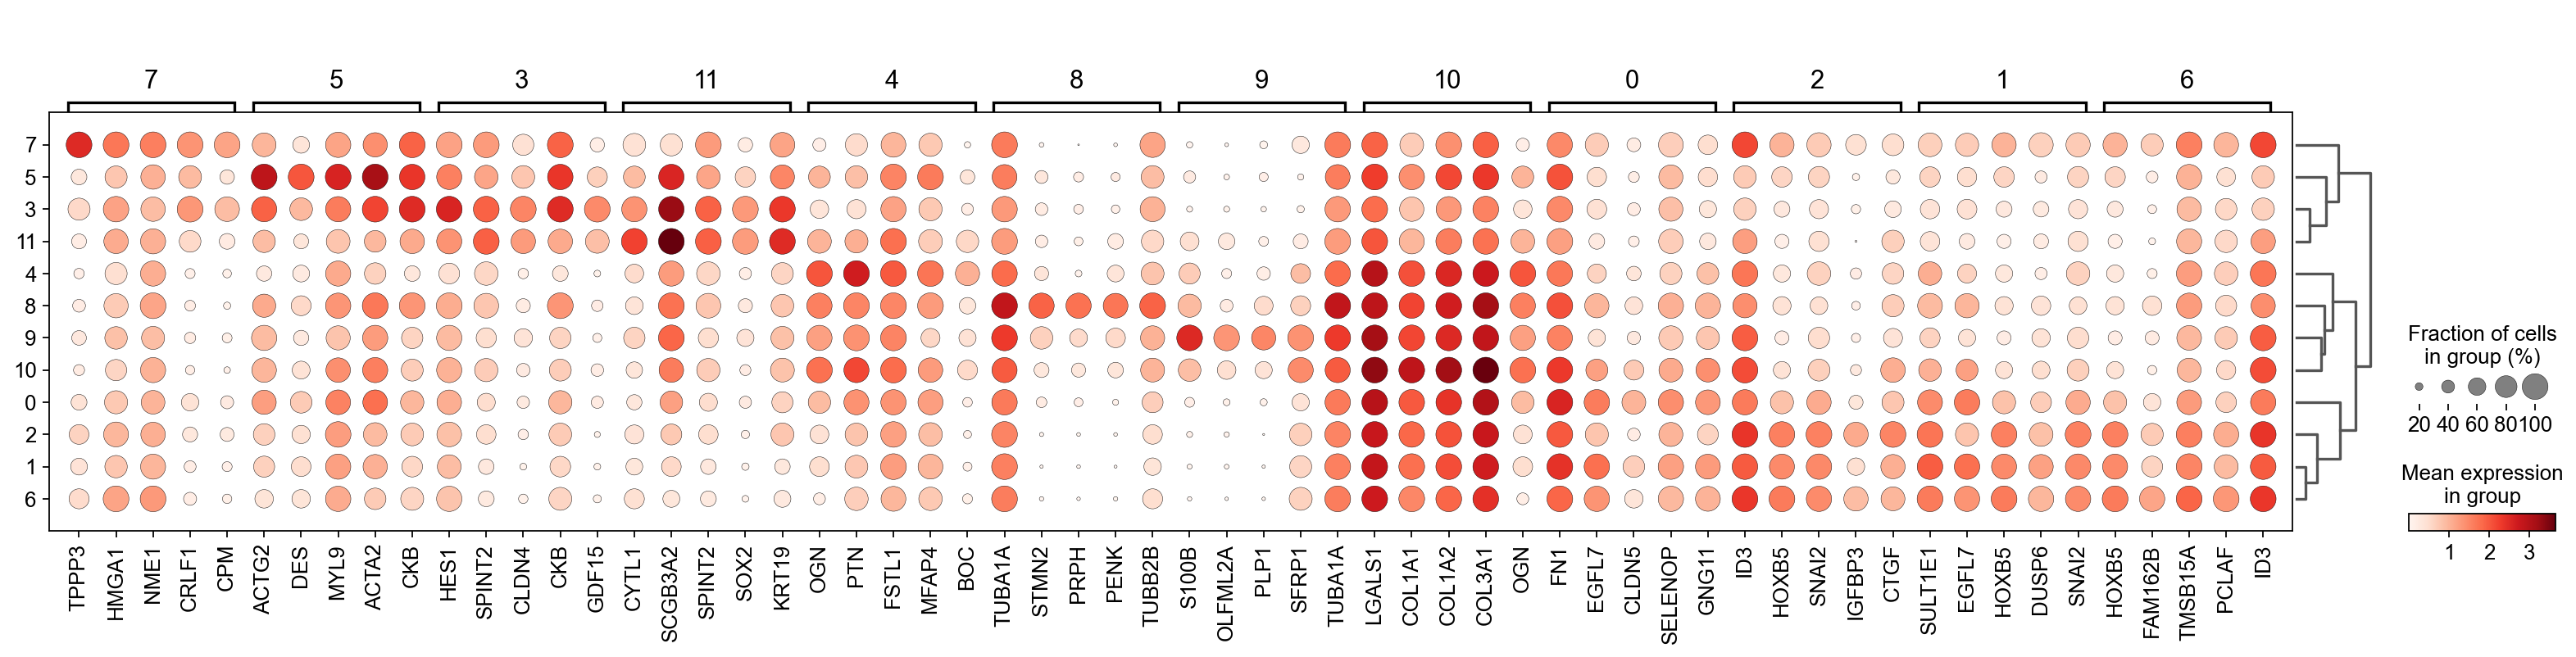

In [35]:
sc.pl.rank_genes_groups_dotplot(
    adata, n_genes=5, groupby="clusters",min_logfoldchange=1)